In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import json
from json import JSONEncoder

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display

import IPython.display

In [2]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.float32):
            return obj.astype(float)
        return JSONEncoder.default(self, obj)

In [3]:
# Data should be placed in the "large_data/" directory, which is not staged in the git repo
metadata = pd.read_csv('large_data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata['length'] = metadata['end']-metadata['start']
metadata.info()
# metadata.describe()
display(metadata)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   length           8732 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 614.1+ KB


,slice_file_name,fsID,start,end,salience,fold,classID,class,length
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,4.000000
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,4.000000
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,4.000000
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,4.000000
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,4.000000
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,2.532098


In [4]:
print(metadata['length'].min())

0.05451700000000015


In [5]:
# Simple way to have a dict relating classID to class
class_dict = {}
for index, row in metadata.iterrows():
    class_dict[row['classID']]=row['class']
print(class_dict)
print(f'Number of unique classes: {len(class_dict)}')

{3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
Number of unique classes: 10


In [6]:
# Function to load wav file with librosa, given a row from metadata table
def load_data(meta_row):
    filename = meta_row['slice_file_name']
    filepath = f'large_data/UrbanSound8K/audio/fold{meta_row["fold"]}/'
    return librosa.load(filepath+filename)

In [7]:
def get_row(metadata, row_ind, class_=None):
    if class_ is not None:
        metadata = metadata[metadata['class']==class_]
    return metadata.iloc[row_ind]

In [8]:
class_ = 'car_horn'
row_ind = -1
row = get_row(metadata, row_ind, class_)

In [9]:
def cross_rate(y, xval):  # Given time series y, gives ratio of points where y crosses xval vs total points. xval=0 gives Zero cross rate
    #print(np.diff(y>xval))
    return np.sum(np.diff(y>xval))/len(y-1)

slice_file_name    102102-3-0-0.wav
fsID                         102102
start                      1.573952
end                        4.673824
salience                          2
fold                              4
classID                           3
class                      dog_bark
length                     3.099872
Name: 100, dtype: object
(68353,)
(257, 535)


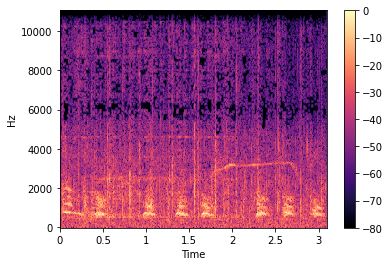

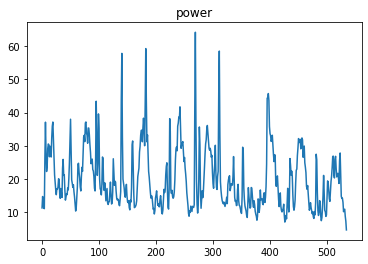

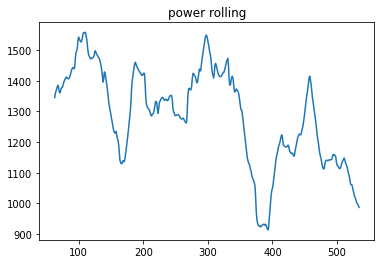

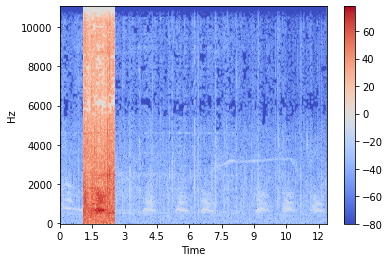

Best window: 110


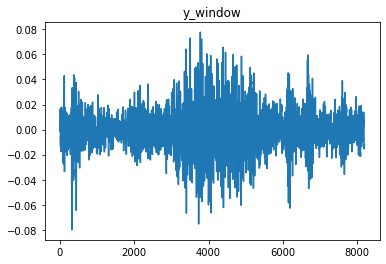

Zero crossing rate: 0.1197509765625


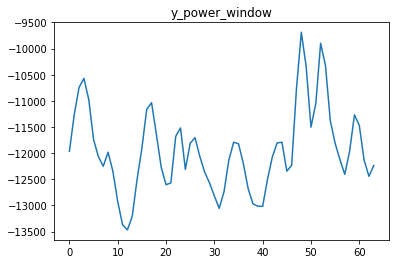

Median crossing rate: 0.265625


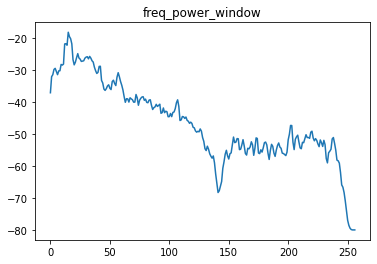

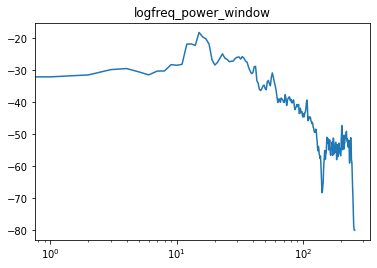

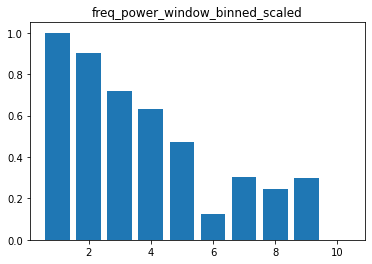

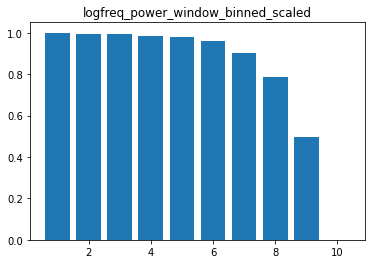

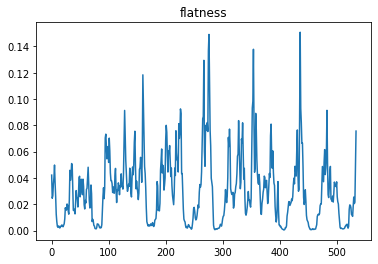

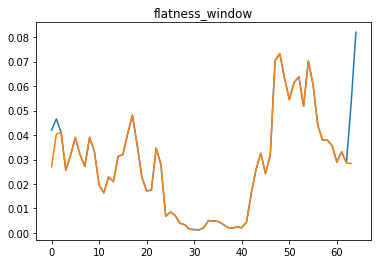

In [13]:
n_fft = 512
hop_length = n_fft//4
freq_min = 0
freq_max = 20000 #25
rolling_length = 64

# Pick a row to visualize the datum
row_ind = 100
#class_ = 'children_playing'
class_ = None
row = get_row(metadata, row_ind, class_)
print(row)
y, sr = load_data(row)
print(y.shape)
ySF, y_phase = librosa.magphase(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
S_db = librosa.amplitude_to_db(ySF, ref=np.max) # Converting to decibell is effectively just a logarithmic transform
print(S_db.shape)

rolling_length = min(rolling_length,S_db.shape[1])

#librosa.display.specshow(S_db[:,:], x_axis='time', y_axis='linear', sr=sr, n_fft=n_fft, hop_length=hop_length)
librosa.display.specshow(S_db[:,:], x_axis='time', y_axis='linear', sr=sr, n_fft=n_fft, hop_length=hop_length)
plt.colorbar()
plt.show()

power = np.sum(ySF[freq_min:freq_max,:],axis=0)
plt.plot(power)
plt.title('power')
plt.show()

power_rolling = pd.Series(power).rolling(rolling_length, center=False).sum()
plt.plot(power_rolling)
plt.title('power rolling')
plt.show()
# print(power_rolling)

best_window_ind = np.argmax(power_rolling)
S_db_highlight = S_db.copy()
S_db_highlight[:,(best_window_ind-rolling_length+1):(best_window_ind+1)]+=80
librosa.display.specshow(S_db_highlight, x_axis='time', y_axis='linear', sr=sr)
plt.colorbar()
plt.show()

print(f'Best window: {best_window_ind}')

y_window = y[(max(best_window_ind-rolling_length+1,0)*hop_length):((best_window_ind+1)*hop_length)]
plt.plot(y_window)
plt.title('y_window')
plt.show()
print(f'Zero crossing rate: {cross_rate(y_window,0)}')

S_db_window = S_db[:,max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
y_power_window = np.sum(S_db_window, axis=0)
freq_power_window = np.sum(S_db_window, axis=1)/rolling_length
plt.plot(y_power_window)
plt.title('y_power_window')
plt.show()
print(f'Median crossing rate: {cross_rate(y_power_window,np.median(y_power_window))}')

plt.plot(freq_power_window)
plt.title('freq_power_window')
plt.show()

plt.semilogx(freq_power_window)
plt.title('logfreq_power_window')
plt.show()

n_bins = 10
bins = np.linspace(0, S_db.shape[0], n_bins+1)
digitized = np.digitize(range(len(freq_power_window)), bins)
#print(digitized)
freq_power_window_binned = [np.sum(freq_power_window[digitized == i]) for i in range(1, len(bins))]
#print(freq_power_window_binned)
freq_power_window_binned_scaled = (freq_power_window_binned-np.min(freq_power_window_binned))/(np.max(freq_power_window_binned)-np.min(freq_power_window_binned))
#print(freq_power_window_binned_scaled)
# plt.plot(freq_power_window_binned_scaled)
plt.bar(range(1, len(bins)), freq_power_window_binned_scaled)
plt.title('freq_power_window_binned_scaled')
plt.show()

n_bins = 10
#bins = np.linspace(0, S_db.shape[0], n_bins+1)
bins = np.logspace(0, np.log10(S_db.shape[0]), n_bins+1)
digitized = np.digitize(range(len(freq_power_window)), bins)
#print(digitized)
freq_power_window_binned = [np.sum(freq_power_window[digitized == i]) for i in range(1, len(bins))]
#print(freq_power_window_binned)
freq_power_window_binned_scaled = (freq_power_window_binned-np.min(freq_power_window_binned))/(np.max(freq_power_window_binned)-np.min(freq_power_window_binned))
#print(freq_power_window_binned_scaled)
# plt.plot(freq_power_window_binned_scaled)
plt.bar(range(1, len(bins)), freq_power_window_binned_scaled)
plt.title('logfreq_power_window_binned_scaled')
plt.show()


flatness = librosa.feature.spectral_flatness(y=y, S=ySF, n_fft=n_fft, hop_length=hop_length)[0]
plt.plot(flatness)
plt.title('flatness')
plt.show()

flatness_window = librosa.feature.spectral_flatness(y=y_window, n_fft=n_fft, hop_length=hop_length)[0]
flatness_window_2 = flatness[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
plt.plot(flatness_window)
plt.plot(flatness_window_2)
plt.title('flatness_window')
plt.show()

#y_f0 = y
#f0 = librosa.yin(y_f0,#frame_length=n_fft,hop_length=hop_length,
#                                             fmin=librosa.note_to_hz('C2'),
#                                             fmax=librosa.note_to_hz('C7'),)
#f0p,_,_ = librosa.pyin(y_f0,#frame_length=n_fft,hop_length=hop_length,
#                                             fmin=librosa.note_to_hz('C2'),
#                                             fmax=librosa.note_to_hz('C7'),)
#times = librosa.times_like(f0,sr=sr#,n_fft=n_fft,hop_length=hop_length
#                          )
##D = S_db
##D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
##librosa.display.specshow(D, x_axis='time', n_fft=n_fft, hop_length=hop_length)
#D = librosa.amplitude_to_db(np.abs(librosa.stft(y_f0)), ref=np.max)
#librosa.display.specshow(D, x_axis='time')
#plt.title('pYIN fundamental frequency estimation')
#plt.colorbar()
#plt.plot(times, f0, label='f0', color='cyan', linewidth=3)
#plt.plot(times, f0p, label='f0', color='yellow', linewidth=3)
##ax.legend(loc='upper right')
#plt.show()
##print(f0)
##print(f0p)
#print(np.sum(np.isnan(f0p))/len(f0p))

max_amp = max(abs(y))
display(IPython.display.Audio(data=y/(max_amp*10), rate=sr, normalize=False))
display(IPython.display.Audio(data=y_window/(max_amp*10), rate=sr, normalize=False))


In [ ]:
spectral_centroid = librosa.feature.spectral_centroid(y=y, S=ySF, n_fft=n_fft, hop_length=hop_length)[0]
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, S=ySF, n_fft=n_fft, hop_length=hop_length)[0]
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, S=ySF, n_fft=n_fft, hop_length=hop_length)[0]
#spectral_rolloff_01 = librosa.feature.spectral_bandwidth(y=y, S=ySF, n_fft=n_fft, hop_length=hop_length, roll_percent=0.01)[0]
#spectral_rolloff_50 = librosa.feature.spectral_bandwidth(y=y, S=ySF, n_fft=n_fft, hop_length=hop_length, roll_percent=0.50)[0]
#spectral_rolloff_85 = librosa.feature.spectral_bandwidth(y=y, S=ySF, n_fft=n_fft, hop_length=hop_length, roll_percent=0.85)[0]
#spectral_rolloff_99 = librosa.feature.spectral_bandwidth(y=y, S=ySF, n_fft=n_fft, hop_length=hop_length, roll_percent=0.99)[0]

times = librosa.times_like(ySF,sr=sr,n_fft=n_fft,hop_length=hop_length)

librosa.display.specshow(S_db, y_axis='log', x_axis='time',n_fft=n_fft,hop_length=hop_length)
plt.plot(times, spectral_centroid, label='Spectral centroid', color='w')
plt.fill_between(times, np.maximum(0, spectral_centroid - spectral_bandwidth),
                np.minimum(spectral_centroid + spectral_bandwidth, sr/2),
                alpha=0.4, label='Centroid +- bandwidth')
plt.plot(times,spectral_rolloff, label='Spectral rolloff', color='blue')
plt.legend(loc='upper right')
plt.show()

In [10]:
def desc_stat(y, name: str):  # Does a bunch of common stats like mean, median, etc
    
    y_nanless = y[~np.isnan(y)]
    if len(y_nanless) == 0:
        return None
    
    if len(name)>0:
        name+='_'
    
    desc_stat = {}
    desc_stat[name+'mean'] = np.mean(y_nanless)
    desc_stat[name+'median'] = np.median(y_nanless)
    desc_stat[name+'std'] = np.std(y_nanless)
    desc_stat[name+'iqr'] = np.quantile(y_nanless,.75) - np.quantile(y_nanless,.25)  # Inter-quartile range
    desc_stat[name+'max'] = np.max(y_nanless)
    desc_stat[name+'min'] = np.min(y_nanless)
    return desc_stat

In [11]:
def power_bands_scaled(f, n_bands, logfreq=False):
    # For f being magnitude as function of frequency,
    # find the total power in n_bands equally divided bands, then scale between 0 and 1
    if logfreq:
        bands = np.logspace(0, np.log10(len(f)), n_bands+1)
    else:
        bands = np.linspace(0, len(f), n_bands+1)
    
    digitized = np.digitize(range(len(f)), bands)
    f_banded = [np.sum(f[digitized == i]) for i in range(1, len(bands))]
    f_banded_scaled = (f_banded-np.min(f_banded))/(np.max(f_banded)-np.min(f_banded))
    
    #plt.bar(range(1, len(bands)), f_banded_scaled)
    #plt.show()
    
    f_banded_scaled = {i:f_banded_scaled[i] for i in range(n_bands)}
    return f_banded_scaled

In [12]:
def engineer_features(row, *, n_fft, hop_length, freq_min, freq_max, rolling_length):
    features = {}
    
    y, sr = load_data(row)
    y_stft_mag, y_stft_phase = librosa.magphase(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(y_stft_mag, ref=np.max) # Converting to decibell is effectively just a logarithmic transform
    
    rolling_length = min(rolling_length,S_db.shape[1])
    
    y_power = np.sum(S_db[freq_min:freq_max,:],axis=0)  # Note here we use 'power' (loosely) to refer to 'sum of log magnitudes'
    y_power_rolling = pd.Series(y_power).rolling(rolling_length, center=False).sum()
    
    best_window_ind = np.argmax(y_power_rolling)  # Finding the window with len=rolling_length that has maximum power
    y_window = y[(max(best_window_ind-rolling_length+1,0)*hop_length):((best_window_ind+1)*hop_length)]
    
    features['y_mw_zcr'] = cross_rate(y_window,0)  # Zero crossing rate of the base signal in the max window
    
    S_db_window = S_db[:,max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    y_power_window = np.sum(S_db_window, axis=0)  # Median crossing rate of the signal's power in the max window
    
    features['y_mw_power_mcr'] = cross_rate(y_power_window,np.median(y_power_window))
    
    spec_flatness = librosa.feature.spectral_flatness(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_flatness_window = spec_flatness[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    
    spec_centroid = librosa.feature.spectral_centroid(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_centroid_window = spec_centroid[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_bandwidth_window = spec_bandwidth[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
    
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, S=y_stft_mag, n_fft=n_fft, hop_length=hop_length)[0]
    spec_rolloff_window = spec_rolloff[max(best_window_ind-rolling_length+1,0):(best_window_ind+1)]
        
    features['spec_flatness'] = desc_stat(spec_flatness,'')
    features['spec_flatness_mw'] = desc_stat(spec_flatness_window,'')
    
    features['spec_centroid'] = desc_stat(spec_centroid,'')
    features['spec_centroid_mw'] = desc_stat(spec_centroid_window,'')

    features['spec_bandwidth'] = desc_stat(spec_bandwidth,'')
    features['spec_bandwidth_mw'] = desc_stat(spec_bandwidth_window,'')
    
    features['spec_rolloff'] = desc_stat(spec_rolloff,'')
    features['spec_rolloff_mw'] = desc_stat(spec_rolloff_window,'')
    
    freq_power_window = np.sum(S_db_window, axis=1)/rolling_length
    
    features['bands_mw_5'] = power_bands_scaled(freq_power_window,5)
    features['bands_mw_10'] = power_bands_scaled(freq_power_window,10)
    features['bands_mw_20'] = power_bands_scaled(freq_power_window,20)
    
    features['logbands_mw_5'] = power_bands_scaled(freq_power_window,5,logfreq=True)
    features['logbands_mw_10'] = power_bands_scaled(freq_power_window,10,logfreq=True)
    features['logbands_mw_20'] = power_bands_scaled(freq_power_window,20,logfreq=True)
    
    return features

In [22]:
%%time

stft_config_roll128 = {
    'n_fft' : 512, # 512,2048
    'hop_length' : 512//4, # n_fft//4
    'freq_min' : 0,
    'freq_max' : 20000, # 25,inf
    'rolling_length' : 128 # 32,64,128
}

stft_config_roll64 = {
    'n_fft' : 512, # 512,2048
    'hop_length' : 512//4, # n_fft//4
    'freq_min' : 0,
    'freq_max' : 20000, # 25,inf
    'rolling_length' : 64 # 32,64,128
}

stft_config_roll32 = {
    'n_fft' : 512, # 512,2048
    'hop_length' : 512//4, # n_fft//4
    'freq_min' : 0,
    'freq_max' : 20000, # 25,inf
    'rolling_length' : 32 # 32,64,128
}


features = []

#for i in range(1):
for i in range(len(metadata)):
    if i % 10 == 0:
        print(i)
    row = get_row(metadata, i)
    row_features_roll32 = engineer_features(row, **stft_config_roll32)
    row_features_roll64 = engineer_features(row, **stft_config_roll64)
    row_features_roll128 = engineer_features(row, **stft_config_roll128)
    features.append({
        'roll_32':row_features_roll32,
        'roll_64':row_features_roll64,
        'roll_128':row_features_roll128
    })


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [23]:
with open('large_data/engineered_features.json', 'w') as outfile:
    json.dump(features, outfile, cls=NumpyArrayEncoder)

In [24]:
print(len(features))
json_str = json.dumps(features[0], cls=NumpyArrayEncoder, indent=4)
print(json_str)

8732
{
    "roll_32": {
        "y_mw_zcr": 0.135986328125,
        "y_mw_power_mcr": 0.0625,
        "spec_flatness": {
            "mean": 0.007301539648324251,
            "median": 0.006863013841211796,
            "std": 0.0036821241956204176,
            "iqr": 0.002932109637185931,
            "max": 0.021534975618124008,
            "min": 0.0007378087029792368
        },
        "spec_flatness_mw": {
            "mean": 0.0075287604704499245,
            "median": 0.0068862102925777435,
            "std": 0.003474564291536808,
            "iqr": 0.0030737873166799545,
            "max": 0.014757556840777397,
            "min": 0.0007378087029792368
        },
        "spec_centroid": {
            "mean": 2072.376614397756,
            "median": 2099.2066996649964,
            "std": 204.1421770940014,
            "iqr": 218.29424473084532,
            "max": 2461.6210242202706,
            "min": 1410.170435813127
        },
        "spec_centroid_mw": {
            "mean": 2

In [25]:
features_df = pd.json_normalize(features)
features_df.info()
features_df.head(10)
#print(features_df.columns.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Columns: 360 entries, roll_32.y_mw_zcr to roll_128.logbands_mw_20.19
dtypes: float32(240), float64(120)
memory usage: 16.0 MB


,roll_32.y_mw_zcr,roll_32.y_mw_power_mcr,roll_32.spec_flatness.mean,roll_32.spec_flatness.median,roll_32.spec_flatness.std,roll_32.spec_flatness.iqr,roll_32.spec_flatness.max,roll_32.spec_flatness.min,roll_32.spec_flatness_mw.mean,roll_32.spec_flatness_mw.median,...,roll_128.logbands_mw_20.10,roll_128.logbands_mw_20.11,roll_128.logbands_mw_20.12,roll_128.logbands_mw_20.13,roll_128.logbands_mw_20.14,roll_128.logbands_mw_20.15,roll_128.logbands_mw_20.16,roll_128.logbands_mw_20.17,roll_128.logbands_mw_20.18,roll_128.logbands_mw_20.19
0,0.135986,0.06250,0.007302,0.006863,0.003682,0.002932,0.021535,0.000738,0.007529,0.006886,...,0.959228,0.956011,0.919508,0.901375,0.847516,0.760590,0.618048,0.434596,0.256670,0.0
1,0.194580,0.18750,0.011270,0.009636,0.006746,0.007716,0.054017,0.001534,0.009449,0.008758,...,0.957209,0.953224,0.930364,0.903452,0.876376,0.834565,0.748861,0.540045,0.328423,0.0
2,0.096436,0.37500,0.008501,0.007698,0.004740,0.005425,0.047758,0.001180,0.005622,0.005595,...,0.955252,0.962662,0.930562,0.892188,0.839806,0.793814,0.700622,0.483725,0.279222,0.0
3,0.184814,0.12500,0.020530,0.012416,0.025892,0.013284,0.175634,0.001876,0.082451,0.094452,...,0.956989,0.945573,0.914709,0.901231,0.852738,0.810400,0.728246,0.515547,0.349555,0.0
4,0.130859,0.37500,0.009634,0.008831,0.004951,0.005842,0.045587,0.001646,0.009653,0.009022,...,0.954739,0.950009,0.924492,0.908894,0.875890,0.816016,0.755140,0.531249,0.293928,0.0
5,0.051514,0.37500,0.008061,0.006077,0.006143,0.006822,0.038134,0.000918,0.006110,0.005846,...,0.952931,0.948540,0.920655,0.896982,0.853180,0.800417,0.709674,0.515562,0.305050,0.0
6,0.102783,0.12500,0.008983,0.007123,0.008071,0.006553,0.078279,0.000879,0.016830,0.012745,...,0.953328,0.944303,0.914869,0.888127,0.853522,0.803973,0.729147,0.543208,0.311699,0.0
7,0.103516,0.34375,0.009936,0.008299,0.006241,0.006973,0.038030,0.001426,0.009519,0.008668,...,0.958940,0.956656,0.933722,0.900736,0.854133,0.809528,0.736256,0.566352,0.332160,0.0
8,0.071777,0.25000,0.004801,0.003790,0.004359,0.003455,0.078768,0.000720,0.007087,0.005585,...,0.962004,0.959466,0.932142,0.907581,0.872599,0.828367,0.770580,0.579574,0.323232,0.0
9,0.155762,0.06250,0.027538,0.015631,0.092947,0.015798,1.000001,0.002485,0.026375,0.026257,...,0.965686,0.947917,0.916963,0.880936,0.829858,0.737177,0.635401,0.512120,0.342714,0.0


In [26]:
features_df.to_csv('large_data/engineered_features.csv')

slice_file_name    101848-9-0-1.wav
fsID                         101848
start                           0.5
end                             4.5
salience                          1
fold                              7
classID                           9
class                  street_music
length                          4.0
Name: 95, dtype: object


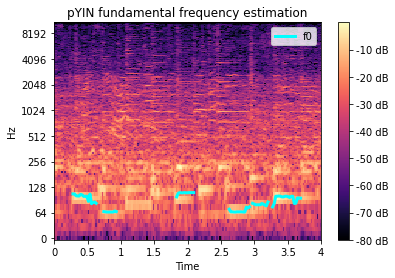

0.4682080924855492


In [16]:
row_ind = 1
class_ = 'street_music'
#class_ = None
row = get_row(metadata, row_ind, class_)
print(row)
y, sr = load_data(row)

f0, voiced_flag, voiced_probs = librosa.pyin(y,fmin=librosa.note_to_hz('C2'),fmax=librosa.note_to_hz('C7'))
#f0, voiced_flag, voiced_probs = librosa.pyin(y,fmin=librosa.note_to_hz('C5'),fmax=librosa.note_to_hz('C9'))
#f0 = librosa.yin(y,fmin=librosa.note_to_hz('C2'),fmax=librosa.note_to_hz('C7'))

times = librosa.times_like(f0)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')
plt.show()

print(1-np.sum(np.isnan(f0))/len(f0))

max_amp = max(abs(y))
display(IPython.display.Audio(data=y/(max_amp*10), rate=sr, normalize=False))

In [16]:
def f0_signal(y, fmin, fmax):  
    f0, _, _ = librosa.pyin(y,fmin=fmin,fmax=fmax)
    features = {}
    f0_stats = desc_stat(f0,'f0')
    if f0_stats is not None:
        features['f0_stats'] = f0_stats
    features['f0_signal'] = 1-np.sum(np.isnan(f0))/len(f0) # value from 0 to 1, indicating how much of the sample is discerned to have a fundamental frequency
    return features

In [ ]:
fmin,fmax = librosa.note_to_hz('C2'),librosa.note_to_hz('C7')
#fmin,fmax = librosa.note_to_hz('C5'),librosa.note_to_hz('C9')

row_ind = 8
#class_ = 'street_music'
class_ = None
row = get_row(metadata, row_ind, class_)
print(row)
y, sr = load_data(row)
print(f0_signal(y,fmin,fmax))

In [31]:
%%time

feature_f0 = []

#for i in range(1):
for i in range(len(metadata)):
    if i % 10 == 0:
        print(i)
    row = get_row(metadata, i)
    y, sr = load_data(row)
    range_low = f0_signal(y,librosa.note_to_hz('C2'),librosa.note_to_hz('C7'))
    range_high = f0_signal(y,librosa.note_to_hz('C5'),librosa.note_to_hz('C9'))
    feature_f0.append({
        'range_low':range_low,
        'range_high':range_high
    })

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [29]:
print(len(feature_f0))
json_str = json.dumps(feature_f0[0], cls=NumpyArrayEncoder, indent=4)
print(json_str)

10
{
    "range_low": {
        "f0_signal": 0.0
    },
    "range_high": {
        "f0_stats": {
            "f0_mean": 551.1907296340232,
            "f0_median": 552.7688074741802,
            "f0_std": 4.497652407600203,
            "f0_iqr": 7.156486933814222,
            "f0_max": 557.5766672463072,
            "f0_min": 544.8415985660738
        },
        "f0_signal": 0.5714285714285714
    }
}


In [32]:
with open('large_data/engineered_features_f0.json', 'w') as outfile:
    json.dump(feature_f0, outfile, cls=NumpyArrayEncoder)

In [33]:
feature_f0_df = pd.json_normalize(feature_f0)
feature_f0_df.info()
feature_f0_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   range_low.f0_signal            8732 non-null   float64
 1   range_high.f0_stats.f0_mean    6372 non-null   float64
 2   range_high.f0_stats.f0_median  6372 non-null   float64
 3   range_high.f0_stats.f0_std     6372 non-null   float64
 4   range_high.f0_stats.f0_iqr     6372 non-null   float64
 5   range_high.f0_stats.f0_max     6372 non-null   float64
 6   range_high.f0_stats.f0_min     6372 non-null   float64
 7   range_high.f0_signal           8732 non-null   float64
 8   range_low.f0_stats.f0_mean     6153 non-null   float64
 9   range_low.f0_stats.f0_median   6153 non-null   float64
 10  range_low.f0_stats.f0_std      6153 non-null   float64
 11  range_low.f0_stats.f0_iqr      6153 non-null   float64
 12  range_low.f0_stats.f0_max      6153 non-null   f

,range_low.f0_signal,range_high.f0_stats.f0_mean,range_high.f0_stats.f0_median,range_high.f0_stats.f0_std,range_high.f0_stats.f0_iqr,range_high.f0_stats.f0_max,range_high.f0_stats.f0_min,range_high.f0_signal,range_low.f0_stats.f0_mean,range_low.f0_stats.f0_median,range_low.f0_stats.f0_std,range_low.f0_stats.f0_iqr,range_low.f0_stats.f0_max,range_low.f0_stats.f0_min
0,0.000000,551.190730,552.768807,4.497652,7.156487,557.576667,544.841599,0.571429,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,2279.768303,2282.437616,170.241756,328.066133,2517.936841,2080.949703,0.109827,NaN,NaN,NaN,NaN,NaN,NaN
2,0.080925,1761.847747,1941.594727,405.183075,850.982713,2230.306669,1077.167118,0.294798,1128.712229,1115.153334,36.960305,57.225801,1195.191751,1077.167118
3,0.000000,552.046160,523.251131,41.031176,53.988435,666.915289,523.251131,0.260116,NaN,NaN,NaN,NaN,NaN,NaN
4,0.040462,2128.539240,2129.589597,36.620152,49.205062,2191.991335,2057.047957,0.156069,66.850514,65.785287,1.875716,1.731598,70.915367,65.406391
5,0.549133,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,71.664066,68.499729,6.619412,11.996459,87.307058,65.406391
6,0.127168,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,66.324975,65.406391,1.633327,0.952187,71.326176,65.406391
7,0.566474,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,73.038573,70.100835,7.721365,12.181207,98.566561,65.406391
8,0.843931,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,70.221166,66.549675,7.497901,6.748554,103.228180,65.406391
9,0.000000,703.347267,702.514299,21.894254,26.279199,744.275557,674.664472,0.285714,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
feature_f0_df.to_csv('large_data/engineered_features_f0.csv')